In [1]:
import torch 
import torch.nn as nn


class CONV(nn.Module):
    def __init__(self):
        super(CONV, self).__init__()
        self.fc0 = nn.Sequential(*[nn.Linear(2 ,64)])
        self.conv1 = nn.Sequential(*[nn.Conv2d(64, 64, kernel_size=3, padding=1)])
        self.conv2 = nn.Sequential(*[nn.Conv2d(64, 64, kernel_size=3, padding=1)])
        self.conv3 = nn.Sequential(*[nn.Conv2d(64, 64, kernel_size=3, padding=1)])
        self.conv4 = nn.Sequential(*[nn.Conv2d(64, 64, kernel_size=3, padding=1)])
        
        self.fc1 = nn.Sequential(*[nn.Linear(64 ,1)])

    def forward(self, x):

        x = self.fc0(x)
        x = x.permute(0, 2, 1).unsqueeze(-1)
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = torch.tanh(self.conv3(x))
        x = torch.tanh(self.conv4(x))
        x = x.squeeze(-1).permute(0, 2, 1)
        x = self.fc1(x)
        return x
    





In [17]:
import torch as tf
import numpy as np
import time


def ui(x, y , model):
    return model(torch.cat((x.unsqueeze(-1), y.unsqueeze(-1)), dim=-1))

def f(x, y ,model):
    x.requires_grad_(True)
    y.requires_grad_(True)
    u = ui(x, y ,model)
   
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True,retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True,retain_graph=True)[0]

    
    
    return u_xx + u_yy 




def f2(x, y ,model):
    
    f_pred = f(x, y ,model)
    r = (f_pred - tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )
    return torch.abs(r)
def adaptive_collocation_points(x, y, model, k=1.0):
   
    residuals = f2(x, y, model)
    
    p = residuals**k / torch.sum(residuals**k)
    indices = torch.multinomial(p.flatten(), num_samples=p.numel(), replacement=True)
    x_new = x.flatten()[indices].unsqueeze(1)
    y_new = y.flatten()[indices].unsqueeze(1)

    #x_new += (torch.rand_like(x_new) - 0.5) * 0.05
    #y_new += (torch.rand_like(y_new) - 0.5) * 0.05
    return x_new, y_new
#initial and boundary conditions losses
def loss_boundary_1(x , model):
    u_pred = ui(x, -torch.ones_like(x),model)
    u_boundary =  100*torch.exp(-10*(x**2+1))
    u_boundary = u_boundary.unsqueeze(-1)
    
    
    

    return torch.mean((u_pred - u_boundary)**2)
def loss_boundary_2(x,model):

    
    
    u_pred = ui(x, torch.ones_like(x),model)
    u_boundary =  100*torch.exp(-10*(x**2+1))
    u_boundary = u_boundary.unsqueeze(-1)
    
    

    return torch.mean((u_pred - u_boundary)**2)

def loss_boundary_3(y,model):
    u_pred = ui(torch.ones_like(y),y,model)
    u_boundary =  100*torch.exp(-10*(y**2+1))
    u_boundary = u_boundary.unsqueeze(-1)
    
    

    return torch.mean((u_pred - u_boundary)**2)

def loss_boundary_4(y ,model):
    u_pred = ui(-torch.ones_like(y),y,model)
    u_boundary =  100*torch.exp(-10*(y**2+1))
    u_boundary = u_boundary.unsqueeze(-1)
    
    

    return torch.mean((u_pred - u_boundary)**2)
def check_for_interrupt():
    try:
        time.sleep(0)
    except KeyboardInterrupt:
        print("Interrupted!")
        raise KeyboardInterrupt

# pde loss

def loss_fn(x, y ,model ):

    f_pred = f(x, y ,model)

    f_exact = torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) +torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2)
    
    #f_exact = f_exact.unsqueeze(-1)
    
    return torch.mean((f_pred-f_exact)**2) 

def create_grid(num_points):
    x = np.linspace(-1, 1, num_points)
    y = np.linspace(-1, 1, num_points)
    x_grid, y_grid = np.meshgrid(x, y)
    x_grid = x_grid.flatten()
    y_grid = y_grid.flatten()
    return x_grid, y_grid

# Step 2: Randomly select points from the grid
def select_random_points(x_grid, y_grid, num_samples):
    indices = np.random.choice(len(x_grid), num_samples, replace=False)
    selected_x = x_grid[indices]
    selected_y = y_grid[indices]
    return selected_x, selected_y




In [22]:
model = CONV()
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)
x, y = torch.meshgrid(x, y)

weight_bc = torch.tensor(1.0, requires_grad=True)
weight_i = torch.tensor(1.0, requires_grad=True)
weight_f = torch.tensor(1.0, requires_grad=True)

MSE = []
L2_ERROR = []
LOSS = []

W_i =[]
W_bc = []
W_f = []

optimizer = torch.optim.Adam([{'params':model.parameters()} ,{'params':[weight_bc, weight_i, weight_f]} ], lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)


for epoch in range(700):
    optimizer.zero_grad()
    
    loss2 = loss_boundary_1(x, model)
    loss3 = loss_boundary_2(x, model)
    loss4 = loss_boundary_3(y, model)
    loss5 = loss_boundary_4(y, model)
    loss_f = loss_fn(x, y, model)

    loss = ((loss_f )*tf.exp(-weight_f) +  (loss3 + loss4)*tf.exp(-weight_bc) + (loss2 + loss5)*tf.exp(-weight_i) + torch.abs(weight_bc)**2 + torch.abs(weight_i)**2 + torch.abs(weight_f)**2)*0.5
    loss.backward(retain_graph=True)
    
    
    optimizer.step()
    scheduler.step()
    
    W_i.append(tf.exp(-weight_i).detach().numpy())
    W_bc.append(tf.exp(-weight_bc).detach().numpy())
    W_f.append(tf.exp(-weight_f).detach().numpy())
    
    if epoch%100 == 0:
        u_pred = ui(x, y,model).reshape(100,100)
        u_ex = torch.exp(-10 * (x**2 + y**2))
        MSE.append(tf.mean((u_ex - u_pred) ** 2).item())
        LOSS.append(loss.item())
        L2_ERROR.append(torch.linalg.norm((u_ex - u_pred) ** 2)/torch.linalg.norm((u_ex ) ** 2).item())

        print(f'Epoch {epoch}, Loss {loss.item()}, mse : {MSE[-1]},l2_error: {L2_ERROR[-1]}')
      
    

Epoch 0, Loss 7.165031909942627, mse : 0.03742734342813492,l2_error: 0.9808187484741211
Epoch 100, Loss 1.3701910972595215, mse : 0.0003787333844229579,l2_error: 0.006470255088061094
Epoch 200, Loss 1.1601876020431519, mse : 4.4576583604793996e-05,l2_error: 0.0007617324008606374
Epoch 300, Loss 1.0006252527236938, mse : 3.531468610162847e-05,l2_error: 0.00048653664998710155
Epoch 400, Loss 0.8696686029434204, mse : 3.1174407922662795e-05,l2_error: 0.00042614847188815475
Epoch 500, Loss 0.7823294997215271, mse : 0.0046149748377501965,l2_error: 0.04294104129076004
Epoch 600, Loss 0.67131108045578, mse : 3.240822843508795e-05,l2_error: 0.00040145800448954105


torch.Size([100, 100])


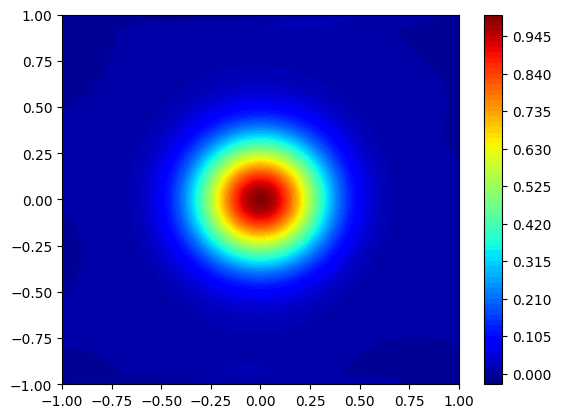

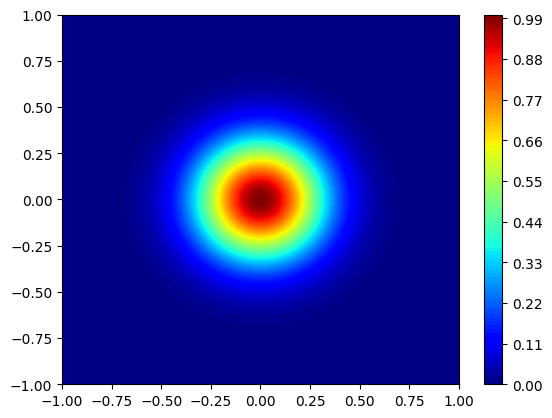

In [30]:
import matplotlib.pyplot as plt
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)
x, y = torch.meshgrid(x, y)
u_exact = torch.exp(-10 * (x**2 + y**2))
u= ui(x, y ,model)
print(u_pred.shape)
plt.contourf(x,y,u_pred.detach().numpy().reshape(100,100),levels=100,cmap='jet')
plt.colorbar()
plt.show()


plt.contourf(x,y,u_exact,levels = 100,cmap='jet')
plt.colorbar()
plt.show()